<a href="https://colab.research.google.com/github/XU2024/Lab-analysis-6/blob/main/Copy_of_Last_Lab6Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title $\gets$ Run Me First (I have the code setup and function definitions)


import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
from bisect import bisect_left, bisect_right
import os, glob
import itertools,operator
from timeit import default_timer as timer
from enum import Enum
import json
from sklearn import linear_model, datasets
from scipy import signal
import scipy.stats

gaccel = 9.802
deghr = np.rad2deg(3600)

plt.rcParams['figure.figsize'] = [8, 5]

class emptystruct:
  pass

def findAngleFiles (startdir):
  #(angleFiles,magFiles) = findSlopeAndAmplitudeFiles(startdir)
  # input stardir: path to directory containing experiments
  # output: list of paths to angle files
  # output slopeFiles: dictionary with paths to slope files, key names are taken from directories under large bob
  #   e.g. if large bob has a directory 2mm, then
  #   slopeFiles["2mm"] is a list of paths to all slope files (end _slope.txt) 
  #   under this directory, even in subdirectories
  # output amplitudeFiles: same as slopeFiles, but paths to all files ending _angle.txt
  #https://stackoverflow.com/questions/3964681/find-all-files-in-a-directory-with-extension-txt-in-python
  #https://www.kite.com/python/answers/how-to-search-for-specific-files-in-subdirectories-in-python
    #look 1,2, and 3 levels down
    return sorted (glob.glob(startdir + '/**/**/*_angle.txt') + glob.glob(startdir + '/**/*_angle.txt') + glob.glob(startdir + '/**/**/**/*_angle.txt') )
def rreplace(s, old, new, occurrence):
  #replace last instance https://stackoverflow.com/questions/2556108/rreplace-how-to-replace-the-last-occurrence-of-an-expression-in-a-string/59082116#59082116
  li = s.rsplit(old, occurrence)
  return new.join(li)

# needed to check data validity
# returns the indices of the first and last element of the largest sequence of true in a list of booleans
def longestTrueSequence(seq):
  #adapted from https://stackoverflow.com/questions/40166522/find-longest-sequence-of-0s-in-the-integer-list
  r = max((list(y) for (x,y) in itertools.groupby((enumerate(seq)),operator.itemgetter(1)) if x), key=len)
  return (r[0][0], r[-1][0])

# Checking data validity (no missed swings, dt reasonable)
# returns longest sequence of valid data
def timeCheck(time,number):
  dt = np.diff(time)
  period = np.median(dt)
  dn = np.diff(number)%256 #number is mod 256
  maxperiod = 5 #equivalent to 6 meter pendulum
  valid = (np.abs(dt -period) < 0.25*period) & (dn<=8)
  (start,stop) = longestTrueSequence(valid)
  return (start,stop)
  

def loadAndParseData (angleFilePath): #450k readings = 1500s
  tcross, theta, majaxis, minaxis, number = np.loadtxt(angleFilePath, skiprows = 1, unpack = True)
  dn = np.diff(number)
  for i in range(len(dn)):
    if dn[i] < 0:
      number[i+1:] = number[i+1:] + 256
  dt = np.gradient(tcross)
  period = np.median(dt)
  valid = np.isfinite(tcross) & np.isfinite(theta) & (majaxis > 0) & (np.abs(dt -period) < 0.25*period)
  experiment = emptystruct()
  experiment.anglePath = angleFilePath
  experiment.t = tcross[valid]
  experiment.theta = theta[valid]
  experiment.number = number[valid]
  return experiment


def updateExperiments(startdir, experiments):
  angleFiles = findAngleFiles(startdir)
  for file in angleFiles:
    found = False
    for e in experiments:
      if os.path.normpath(file) == os.path.normpath(e.anglePath):
        found = True
    if not(found):
      print('loading: {}'.format(file))
      e = loadAndParseData(file)
      experiments.append(e)

#(m,b,m_e,b_e) = fitLine(x,y)
#least squares fit to y = m x + b : m_e,b_e are uncertainties in m,b
def fitLine(x,y):
  p = np.polyfit(x,y,1)
  res = y - p[0]*x - p[1]
  m_e = np.sqrt(np.var(res)/np.sum((x-np.mean(x))**2))
  b_e = np.sqrt(np.mean(x**2))*m_e
  return (p[0],p[1],m_e,b_e)
  

def fitLineHuber(x,y,epsilon=2):
  huber = linear_model.HuberRegressor(epsilon=epsilon)
  huber.fit(x.reshape(-1,1),y)
  outlier_mask = huber.outliers_
  inlier_mask = np.logical_not(outlier_mask)
  (m,b,me,be) = fitLine(x[inlier_mask], y[inlier_mask])
  xi = x[inlier_mask]
  yi = y[inlier_mask]
  xo = x[outlier_mask]
  yo = y[outlier_mask]
  return (m,b,me,be,xi,yi,xo,yo)

def smoothRateVsTime(t,y,timescale=100):
  sos = signal.bessel(4, 1/timescale, 'low', norm='phase', fs=np.median(np.gradient(t)), output='sos')
  ysm = signal.sosfiltfilt(sos, y)
  tsm = signal.sosfiltfilt(sos,t)
  dydt = (np.gradient(ysm)/np.gradient(tsm))
  return dydt

initialBlockRun = True



## run this block once 
This loads the class data and the long data set from the pendulum in the machine shop

In [2]:
try:
  if not(initialBlockRun):
    raise
except:
  print ("you need to run the code block above first!")
else:  
  experiments = []
  longexperiments = []
  !git clone https://github.com/NYUExperimentalPhysics1-2021/lab6-individual-data-XU2024 data #change to your github user name - do not erase the "data" afterwards
  startdir = '/content/data'
  !git clone https://github.com/NYUExperimentalPhysics1-2021/LongFoucaultPrecessions longdata
  longdir = '/content/longdata'
  updateExperiments(startdir, experiments)
  updateExperiments(longdir, longexperiments)

Cloning into 'data'...
remote: Enumerating objects: 20, done.
remote: Total 20 (delta 0), reused 0 (delta 0), pack-reused 20
Unpacking objects: 100% (20/20), done.
Cloning into 'longdata'...
remote: Enumerating objects: 24, done.
remote: Total 24 (delta 0), reused 0 (delta 0), pack-reused 24
Unpacking objects: 100% (24/24), done.
loading: /content/data/20211130163053/20211130163053_angle.txt
loading: /content/longdata/20211201102239/20211201102239_angle.txt
loading: /content/longdata/20211204193214/20211204193214_angle.txt


##Plot individual experiments and find avg. rates
`(m,b,m_e,b_e) = fitLine(x,y)` fits a line to y = mx + b, me, be are derived errors

1. create empty arrays for rate and rate_eb
1. iterate over all experiments
  1. x is e.t minus the start time
  1. y is the unwrapped angle (note that the angle is in degrees) - also, try unwrapping by 180 instead of 360 degrees
  1. fit x,y to a line
  1. plot x,y as dots an the fit as a line
  1. title with the slope in deg/hr
  1. append m$*$3600 to rate and me$*$3600 to rate_eb

1. convert m and me to numpy arrays


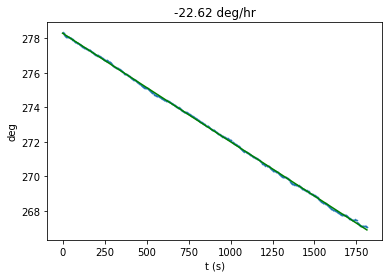

In [3]:
## your code here

rate = []
rate_eb = []

for e in experiments:
  x = e.t - e.t[0]
  y = np.rad2deg(0.5 * np.unwrap(np.deg2rad(e.theta) * 2))
  (m, b, me, be) = fitLine(x, y)
  plt.scatter(x, y, 1, marker=".")
  plt.plot(x, m*x+b, 'g-')
  plt.title("{:.2f} deg/hr".format(m*3600))
  plt.xlabel("t (s)")
  plt.ylabel("deg")
  plt.show()

  rate.append(m * 3600)
  rate_eb.append(me * 3600)

rate = np.array(rate)
rate_eb = np.array(rate_eb)

One of the data sets has bad values that create some huge jumps - either truncate the data set to get a clean continuous run (then rerun the fits) or remove the fit results from rate and rate_eb

In [4]:
## your code here
print(experiments[-1].t[0] + 3000)
experiments[-1].theta = experiments[-1].theta[experiments[-1].t > 4450]
experiments[-1].t = experiments[-1].t[experiments[-1].t > 4450]

4056.1831039999997


1. Print the mean of all the rates
1. Print the mean of all the rates, weighted by their fitting errors. $w_i = \frac{1}{error_i} / \sum_i \frac{1}{error_i}$, $<r> = \sum_i w_i r_i$
1. Some of the plots of angle vs time show that the bob stops precessing or even reverses direction. It looks like most of these rotate with |rate| < 3 deg/hr. Print the average with just the rates whose absolute value > 3 deg/hr (|rates| > 3 deg/hr).
1. Make a plot of the rates of precession in sorted order. X axis is 0 through length(rate) - 1. Y axis is rate. Add a horizontal line for the predicted rate and the mean rate. 
1. Make a histogram of the rates of precession

mean rate = -22.617804 deg/hr
weighted mean rate = -22.62 deg/hr
mean rate (|rate| > 3)= -22.62 deg/hr


(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([-23.11780382, -23.01780382, -22.91780382, -22.81780382,
        -22.71780382, -22.61780382, -22.51780382, -22.41780382,
        -22.31780382, -22.21780382, -22.11780382]),
 <a list of 10 Patch objects>)

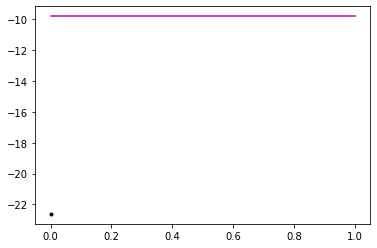

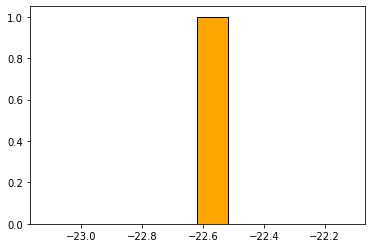

In [5]:
print("mean rate = {:2f} deg/hr".format(np.mean(rate)))
w = 1/rate_eb**2
w = w/np.sum(w)

print("weighted mean rate = {:.2f} deg/hr".format(np.sum(w*rate)))
print("mean rate (|rate| > 3)= {:.2f} deg/hr".format(np.mean(rate[np.abs(rate)>3])))

plt.plot(np.arange(len(rate)), np.sort(rate), 'k.') 
plt.plot([0,len(rate)], [-9.8,-9.8], 'm-')
plt.figure(2)
plt.hist(rate, color='orange', edgecolor='black')

longexperiments has multiple files spanning a single experiment 

combine them by

1. make one array t that concatenates all the times (stored in longexperiments[0].t etc.) - use list comprehension
1. subtract t[0] from the t array 
1. make one array theta that concatenates all the angles (stored in longexperiments[0].theta etc.)

then

1. plot theta vs. time (in hours)
1. notice that the pendulum took some time to `settle in' - remove the first two hours from t and theta
1. plot theta vs. time (in hours) again
1. fit theta vs. time to a line, title the plot with the slope and overlay a fit line on the data
1. Use `rate = smoothRateVsTime(t,y,timescale=100)` to calculate the rate of precession vs. time, with noise smoothed over. `timescale` is the smoothing time in seconds (if t is in seconds). 
1. Plot rate (in deg/hr) vs. time (in hours)



Text(0.5, 1.0, '-9.68')

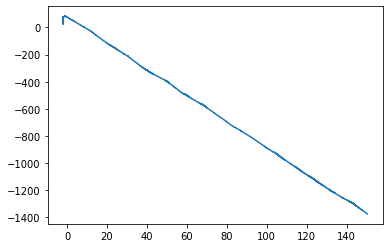

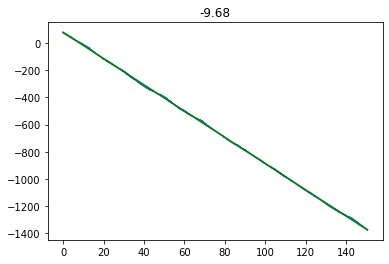

In [6]:
## your coe here
t=np.concatenate([e.t for e in longexperiments])
theta=np.concatenate([e.theta for e in longexperiments])
theta=0.5*np.rad2deg(np.unwrap(np.deg2rad(theta)*2))
t = t-t[0]-7200
plt.plot(t/3600, theta)
theta = theta[t>0]

t = t[t>0]
plt.figure()
plt.plot(t/3600, theta)
(m,b, me, be) = fitLine(t, theta)
plt.plot(t/3600, m*t+b, "g-")
plt.title("{:.2f}".format(m*3600))

<Figure size 432x288 with 0 Axes>

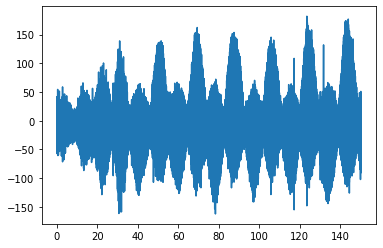

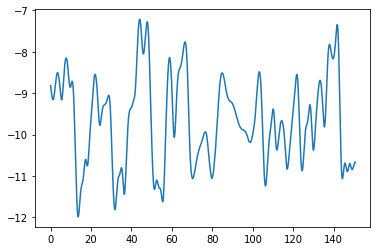

<Figure size 432x288 with 0 Axes>

In [7]:
plt.plot(t/3600, np.gradient(theta)/np.gradient(t) * 3600)
plt.figure()
plt.plot(t/3600,smoothRateVsTime(t, theta,1000)*3600)
plt.figure()

<Figure size 432x288 with 0 Axes>

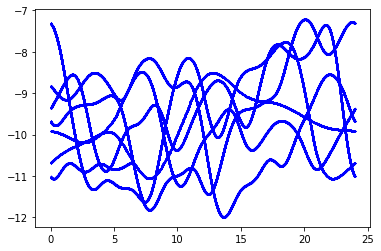

<Figure size 432x288 with 0 Axes>

In [8]:
rate=smoothRateVsTime(t,theta,1000) *3600
plt.plot(np.mod(t/3600, 24),rate,'b.',marker = '.',markersize = 1)
plt.figure()

1. on another graph, plot the difference between theta and the best fit line vs. time- this shows far ahead or behind the pendulum is of its average motion
1. on a new graph, plot the difference between theta and the best fit line vs. time mod 24 hours - is there a daily pattern
1. on a new graph, plot the difference between theta and the best fit line vs. theta mod 180 degrees - is there a spatial pattern

1. on another graph, plot the rate vs. time mod 24 hours - is there a daily pattern
1. on a new graph, plot the rate vs. theta mod 180 degrees - is there a spatial pattern

want to calculate the mean rate as a function of time of day? mean rate as a function of angle mod 180? use `binned_statistic'
`bsr = scipy.stats.binned_statistic(x, values, statistic='mean', bins=10, range=None)`

I wrote an example calculating rate vs. time mod 24 hours 
You write one for rate vs. angle mod 180 in 5 degree bins


<Figure size 432x288 with 0 Axes>

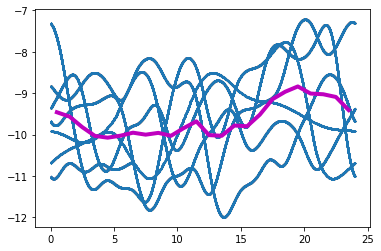

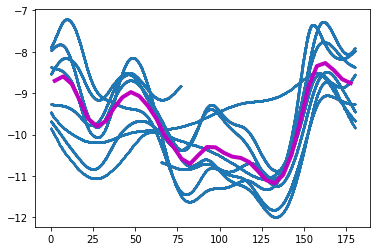

<Figure size 432x288 with 0 Axes>

In [9]:
bsr = scipy.stats.binned_statistic(np.mod(t/3600,24), rate, bins = np.arange(0,24.1,1))
plt.scatter(np.mod(t/3600,24),rate,1,marker = '.')
plt.plot(np.arange(0.5,24,1), bsr.statistic, 'm-',linewidth=4)

plt.figure()
bsr = scipy.stats.binned_statistic(np.mod(theta,180), rate, bins = np.arange(0,180.1,5))
plt.scatter(np.mod(theta,180),rate,1,marker = '.')
plt.plot(np.arange(2.5,180,5),bsr.statistic,'m-',linewidth=4)
plt.figure()